In [5]:
import os
import sys
import re

import time
import random
import warnings

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import make_scorer

from matplotlib import pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000
pd.options.display.max_colwidth = -1

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

RANDOM_STATE = 313
seed_everything(seed=RANDOM_STATE)

sns.set()

# Data Exploration

In [6]:
covid = pd.read_csv('C:/Users/Yashar/Desktop/Data Science Bootcamp/Python programming/Week 8/covid_19_data.csv')

In [7]:
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [8]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6722 entries, 0 to 6721
Data columns (total 8 columns):
SNo                6722 non-null int64
ObservationDate    6722 non-null object
Province/State     3956 non-null object
Country/Region     6722 non-null object
Last Update        6722 non-null object
Confirmed          6722 non-null float64
Deaths             6722 non-null float64
Recovered          6722 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 420.2+ KB


In [9]:
covid.describe(include="all")

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
count,6722.000000,6722,3956,6722,6722,6722.000000,6722.000000,6722.000000
unique,NaN,57,276,179,1637,NaN,NaN,NaN
top,NaN,03/18/2020,Gansu,Mainland China,2020-03-11T20:00:00,NaN,NaN,NaN
freq,NaN,284,59,1765,197,NaN,NaN,NaN
mean,3361.500000,NaN,NaN,NaN,NaN,601.195924,19.855846,226.341267
std,1940.618587,NaN,NaN,NaN,NaN,4896.332140,204.486922,2556.035202
min,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,1681.250000,NaN,NaN,NaN,NaN,2.000000,0.000000,0.000000
50%,3361.500000,NaN,NaN,NaN,NaN,13.000000,0.000000,0.000000
75%,5041.750000,NaN,NaN,NaN,NaN,108.000000,1.000000,11.000000


In [10]:
covid.dtypes

SNo                int64  
ObservationDate    object 
Province/State     object 
Country/Region     object 
Last Update        object 
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object

# Data Preprocessing

In [11]:
# Check for nulls
covid.isnull().sum()

SNo                0   
ObservationDate    0   
Province/State     2766
Country/Region     0   
Last Update        0   
Confirmed          0   
Deaths             0   
Recovered          0   
dtype: int64

In [12]:
# Handle column names
cols = covid.columns
covid.columns = [col.lower() for col in cols]

covid.rename(columns={'observationdate' : 'observation_date', 
                      'country/region' : 'country',
                      'province/state' : 'province',
                      'last update' : 'last_update'}, inplace=True)

covid.head()

,sno,observation_date,province,country,last_update,confirmed,deaths,recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [13]:
sorted(covid.country.unique()) #check if there are duplicated values, which are not correctly typed

[' Azerbaijan',
 "('St. Martin',)",
 'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Central African Republic',
 'Channel Islands',
 'Chile',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'Equatorial Guinea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Faroe Islands',
 'Finland',
 'France',
 'French Guiana',
 'Gabon',
 'Gambia, The',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Guadeloupe',
 'Guam',
 'Guatemala',
 'Guernsey',
 'Guinea',
 'Guyana',
 'Holy See',
 'Honduras

In [14]:
# Handle country names
def clean_country(country):
    country = country.lower().strip()
    country = re.sub(r'[^a-z\s]+', '', country)
    country = 'china' if country == 'mainland china' else country
    return country

covid['country'] = covid['country'].apply(lambda country: clean_country(country))

In [15]:
# Check if the number of cases per country increases monotonically as time passes by, if not, fix it
def check_monotonic_increasing(grp):
    if np.sum(np.diff(grp) < 0) > 0:
        return False
    else:
        return True
    
def force_monotonic_increasing(grp):
    if np.sum(np.diff(grp) < 0) > 0:
        return sorted(grp)
    else:
        return grp

In [16]:
group_country_date = covid.groupby(by=['country', 'observation_date']).agg({'confirmed': 'sum', 'deaths': 'sum', 'recovered': 'sum'}).sort_values(by=['country', 'observation_date'], ascending=[True, True])
group_country = group_country_date.reset_index(level=1, drop=True)
country_date_scores = group_country_date.reset_index()
country_scores = group_country.reset_index()

In [17]:
monitor = country_scores.groupby(by=['country']).transform(lambda grp: check_monotonic_increasing(grp))
monitor = monitor.apply(lambda x: x['confirmed'] and x['deaths'] and x['recovered'], axis=1)
non_monotonic_increase = country_scores.iloc[np.where(monitor == False)]
print(non_monotonic_increase.country.unique())
non_monotonic_increase

['andorra' 'australia' 'austria' 'azerbaijan' 'bahrain' 'egypt' 'guam'
 'guernsey' 'hong kong' 'iceland' 'iraq' 'italy' 'japan' 'jersey'
 'lebanon' 'montenegro' 'occupied palestinian territory' 'others'
 'puerto rico' 'republic of the congo' 'russia' 'saint barthelemy'
 'south korea' 'the gambia']


,country,confirmed,deaths,recovered
57,andorra,1.0,0.0,0.0
58,andorra,1.0,0.0,0.0
59,andorra,1.0,0.0,0.0
60,andorra,1.0,0.0,0.0
61,andorra,1.0,0.0,0.0
62,andorra,1.0,0.0,0.0
63,andorra,1.0,0.0,0.0
64,andorra,1.0,0.0,0.0
65,andorra,1.0,0.0,0.0
66,andorra,1.0,0.0,0.0


In [18]:
monitor = country_scores.groupby(by=['country']).transform(lambda grp: force_monotonic_increasing(grp))
country_scores[monitor.columns] = monitor.values

In [19]:
monitor = country_scores.groupby(by=['country']).transform(lambda grp: check_monotonic_increasing(grp))
monitor = monitor.apply(lambda x: x['confirmed'] and x['deaths'] and x['recovered'], axis=1)
non_monotonic_increase = country_scores.iloc[np.where(monitor == False)]
print(non_monotonic_increase.country.unique())

[]


In [20]:
country_date_scores[country_scores.columns] = country_scores.values

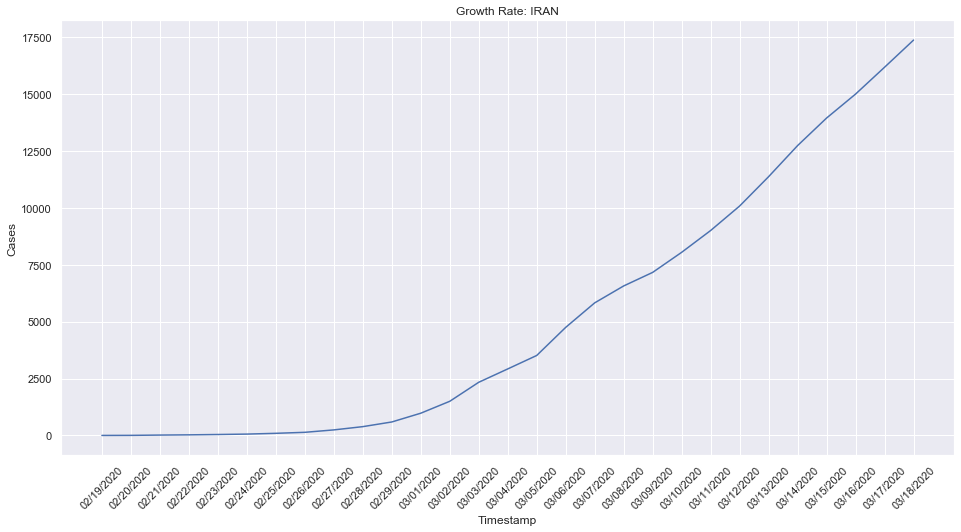

In [21]:
# Plot growth rate for an Area of Interest
area_of_interest = 'iran'
y_data = country_date_scores.loc[country_date_scores.country == area_of_interest, 'confirmed']
x_data = country_date_scores.loc[country_date_scores.country == area_of_interest, 'observation_date']

plt.subplots(1, 1, figsize=(16, 8))
plt.plot(x_data, y_data)
plt.xlabel("Timestamp")
plt.ylabel("Cases")
plt.title(f"Growth Rate: {area_of_interest.upper()}")
plt.xticks(rotation=45)
plt.show()

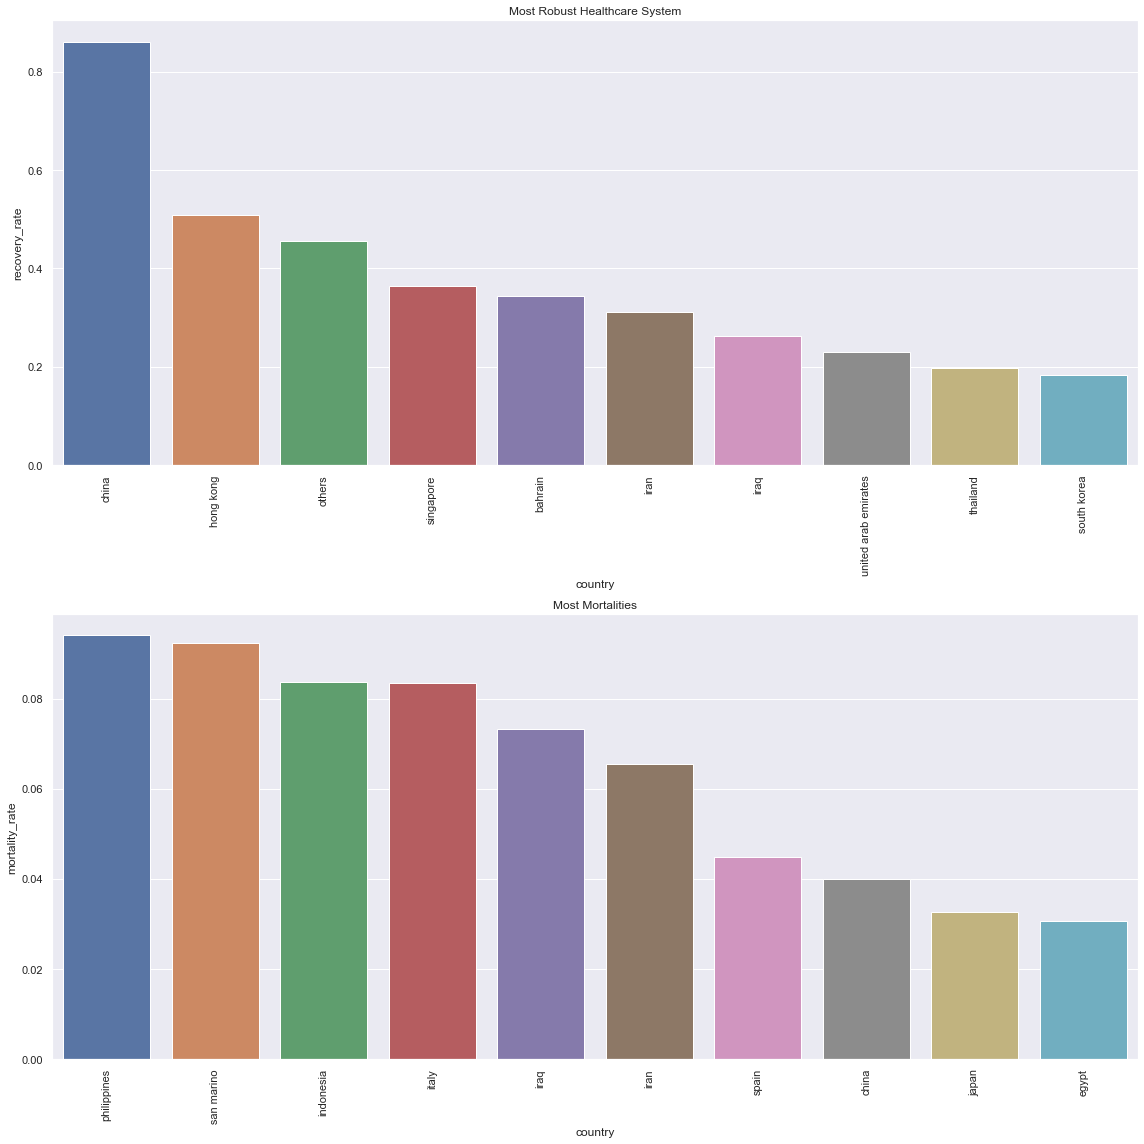

In [22]:
# Most robust healthcare system
# Most mortalities

group_country_scores = country_scores.groupby(by=['country']).agg({'confirmed': 'max', 'deaths': 'max', 'recovered': 'max'})
group_country_scores['recovery_rate'] = group_country_scores['recovered'] / group_country_scores['confirmed']
group_country_scores['mortality_rate'] = group_country_scores['deaths'] / group_country_scores['confirmed']

fig, axes = plt.subplots(2, 1, figsize=(16, 16))

recovery_df = group_country_scores.loc[group_country_scores['confirmed'] > 100, ['recovery_rate']].sort_values(by=['recovery_rate'], ascending=False).head(10)
sns.barplot(x=recovery_df.index, y="recovery_rate", data=recovery_df, ax=axes[0])
axes[0].set_title("Most Robust Healthcare System")
axes[0].xaxis.set_tick_params(rotation=90)

mortality_df = group_country_scores.loc[group_country_scores['confirmed'] > 100, ['mortality_rate']].sort_values(by=['mortality_rate'], ascending=False).head(10)
sns.barplot(x=mortality_df.index, y="mortality_rate", data=mortality_df, ax=axes[1])
axes[1].set_title("Most Mortalities")
axes[1].xaxis.set_tick_params(rotation=90)

fig.tight_layout()
plt.show()

In [23]:
# Check if confirmed cases are greater or equal to the sum of death and recovered cases combined
country_date_scores['check_sum'] = country_date_scores.apply(lambda x: True if x['confirmed'] >= (x['deaths'] + x['recovered']) else False, axis=1)
print(np.sum(~country_date_scores['check_sum']))
country_date_scores.drop(['check_sum'], axis=1, inplace=True)

0


In [24]:
# Convert observation_date to pandas datetime format for further processing
# country_date_scores['observation_date'] = pd.to_datetime(country_date_scores['observation_date'])
country_date_scores['observation_date'] = country_date_scores['observation_date'].map(pd.to_datetime)

In [25]:
date_scores = country_date_scores.groupby(by=['observation_date']).agg({'confirmed': 'sum', 'deaths': 'sum', 'recovered': 'sum'}).reset_index()

In [26]:
# Calculate days_since
date_scores['days_since'] = (date_scores['observation_date'] - date_scores['observation_date'].min()).dt.days

In [27]:
# Check if days_since increases monotonically
assert np.sum(np.diff(date_scores['days_since']) < 0) == 0

In [28]:
# Check if there exists a gap in days_since
last_day = date_scores.iloc[-1]['days_since']
assert date_scores['days_since'].sum() == 0.5 * last_day * (last_day + 1)

In [29]:
# Calculate infected/active cases
date_scores['infected'] = date_scores['confirmed'] - (date_scores['recovered'] + date_scores['deaths'])

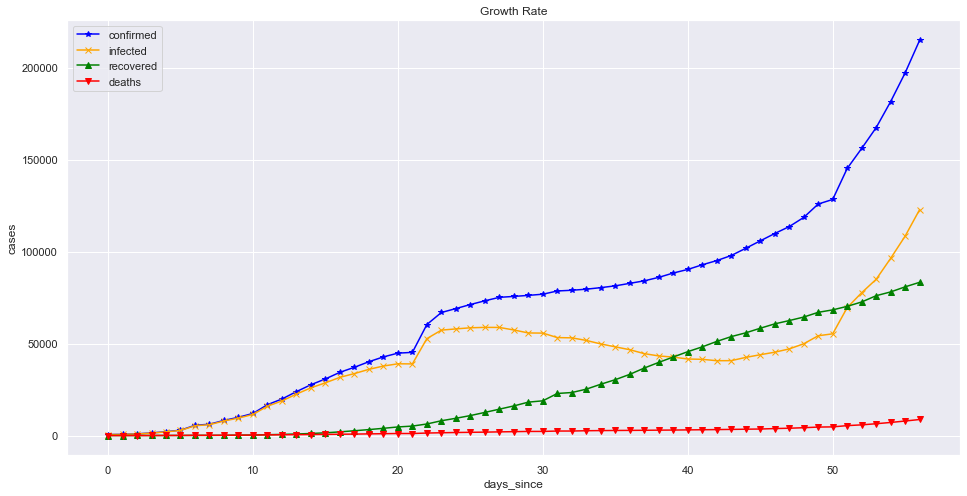

In [30]:
plt.subplots(1, 1, figsize=(16, 8))
plt.plot(date_scores['days_since'], date_scores['confirmed'], label='confirmed', marker='*', color='blue')
plt.plot(date_scores['days_since'], date_scores['infected'], label='infected', marker='x', color='orange')
plt.plot(date_scores['days_since'], date_scores['recovered'], label='recovered', marker='^', color='green')
plt.plot(date_scores['days_since'], date_scores['deaths'], label='deaths', marker='v', color='red')
plt.xlabel("days_since")
plt.ylabel("cases")
plt.title("Growth Rate")
plt.legend(loc='upper left')

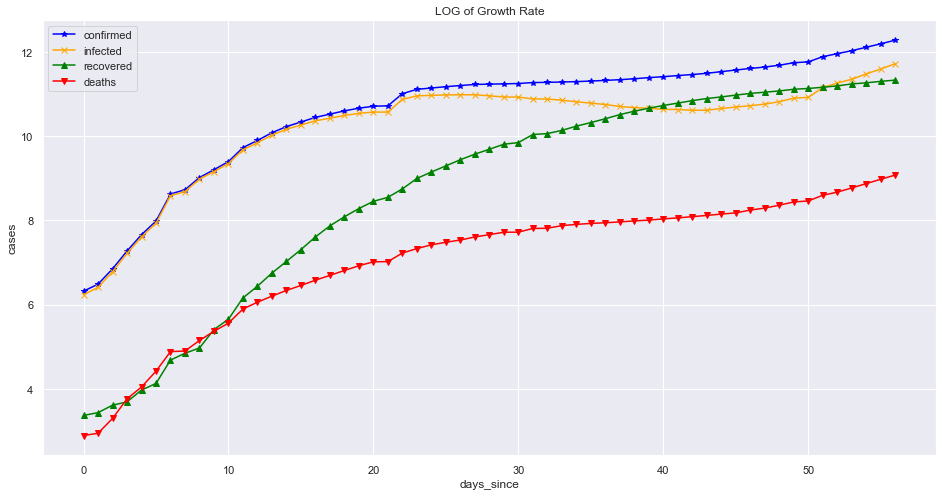

In [31]:
# Better idea?
# Linearization of curves may help to get better performance over the exponential segment
# If you are doing this, make sure that you also inverse the log function when predicting
plt.subplots(1, 1, figsize=(16, 8))
plt.plot(date_scores['days_since'], np.log1p(date_scores['confirmed']), label='confirmed', marker='*', color='blue')
plt.plot(date_scores['days_since'], np.log1p(date_scores['infected']), label='infected', marker='x', color='orange')
plt.plot(date_scores['days_since'], np.log1p(date_scores['recovered']), label='recovered', marker='^', color='green')
plt.plot(date_scores['days_since'], np.log1p(date_scores['deaths']), label='deaths', marker='v', color='red')
plt.xlabel("days_since")
plt.ylabel("cases")
plt.title("LOG of Growth Rate")
plt.legend(loc='upper left')

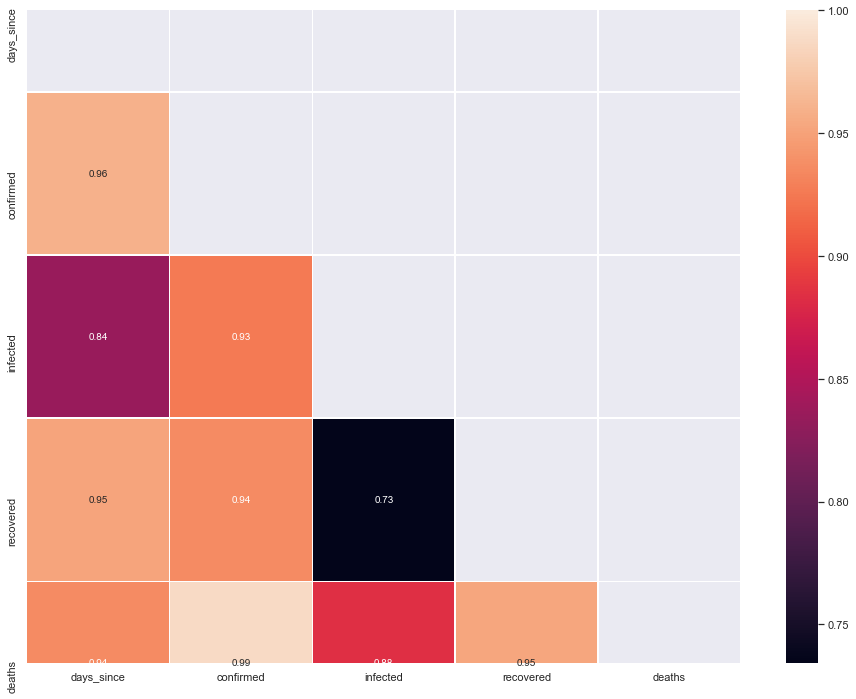

In [32]:
# Correlations

# Set up figure
fig, ax = plt.subplots(figsize=(16, 12))

# Create correlation dataframe
df_corr = date_scores[['days_since', 'confirmed', 'infected', 'recovered', 'deaths']]

# Create correlation matrix
corr = df_corr.corr()

# # Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(h_neg = 220, h_pos=20, sep=10, as_cmap=True)

# Plot correlation matrix without the diagonal and upper part
sns.heatmap(corr, mask=mask, annot=True, linewidths=.5)

# Modeling

In [33]:
date_scores.head()

,observation_date,confirmed,deaths,recovered,days_since,infected
0,2020-01-22,554.0,17.0,28.0,0,509.0
1,2020-01-23,654.0,18.0,30.0,1,606.0
2,2020-01-24,941.0,26.0,36.0,2,879.0
3,2020-01-25,1438.0,42.0,39.0,3,1357.0
4,2020-01-26,2118.0,56.0,52.0,4,2010.0


In [34]:
# Train/Test Split

# train + validation interval: '2020-01-22':'2020-03-09'
# test interval:  '2020-03-10':'2020-03-16'

X_columns = ['days_since']

# Change y_column to one of ('confirmed', 'infected', 'recovered', 'deaths')
# and re-run this cell and cells below
y_column = ['confirmed'] 
    
X_train = np.array(date_scores.loc[date_scores['observation_date'] < '2020-03-10', X_columns])
X_test = date_scores.loc[date_scores['observation_date'] >= '2020-03-10', X_columns]
y_train = np.array(date_scores.loc[date_scores['observation_date'] < '2020-03-10', y_column])
y_test = date_scores.loc[date_scores['observation_date'] >= '2020-03-10', y_column]

In [35]:
# Linear Regression i.e. ElasticNet
enet = ElasticNet(random_state=RANDOM_STATE, normalize=True)
parameters = {'alpha':[1.5, 1.0, 0.75, 0.5], 'l1_ratio':[0, 0.3, 0.5, 0.7, 1.0]}
regressor = GridSearchCV(estimator=enet, 
                         param_grid=parameters, 
                         cv=[(slice(0, 35), slice(35, 48))],
                         scoring={"mse": make_scorer(mean_squared_error, greater_is_better=False), 
                                  "mae": make_scorer(mean_absolute_error, greater_is_better=False), 
                                  "r2": make_scorer(r2_score, greater_is_better=True)},
                         refit="mse",
                         return_train_score=True)

regressor.fit(X_train, y_train)

GridSearchCV(cv=[(slice(0, 35, None), slice(35, 48, None))], error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=313, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1.5, 1.0, 0.75, 0.5],
                         'l1_ratio': [0, 0.3, 0.5, 0.7, 1.0]},
             pre_dispatch='2*n_jobs', refit='mse', return_train_score=True,
             scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False),
                      'mse': make_scorer(mean_squared_error, greater_is_better=False),
                      'r2': make_scorer(r2_score)},
             verbose=0)

In [36]:
cv_results = regressor.cv_results_
cv_results

{'mean_fit_time': array([0.00899315, 0.00099206, 0.00099897, 0.        , 0.00099921,
        0.00199986, 0.00199962, 0.00099945, 0.        , 0.00099993,
        0.00099945, 0.00099945, 0.00099874, 0.        , 0.00099969,
        0.00099921, 0.        , 0.00099945, 0.00099921, 0.        ]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'mean_score_time': array([0.00100017, 0.00099707, 0.00099874, 0.00099945, 0.        ,
        0.        , 0.00100636, 0.00099945, 0.00099945, 0.00099921,
        0.00099945, 0.        , 0.00100136, 0.00099969, 0.        ,
        0.00099969, 0.00099969, 0.        , 0.00099969, 0.00100017]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'param_alpha': masked_array(data=[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75,
                    0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5],
              mask=[False

In [37]:
regressor.best_estimator_

ElasticNet(alpha=1.5, copy_X=True, fit_intercept=True, l1_ratio=1.0,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=313, selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
test_scores = pd.DataFrame()
test_scores['y_true'] = y_test.values.flatten()
test_scores['y_pred'] = regressor.predict(X_test).flatten()
test_scores

,y_true,y_pred
0,118575.0,116479.008422
1,125868.0,119017.269821
2,128352.0,121555.531219
3,145208.0,124093.792617
4,156105.0,126632.054015
5,167421.0,129170.315413
6,181582.0,131708.576812
7,197204.0,134246.838210
8,214927.0,136785.099608


# Results

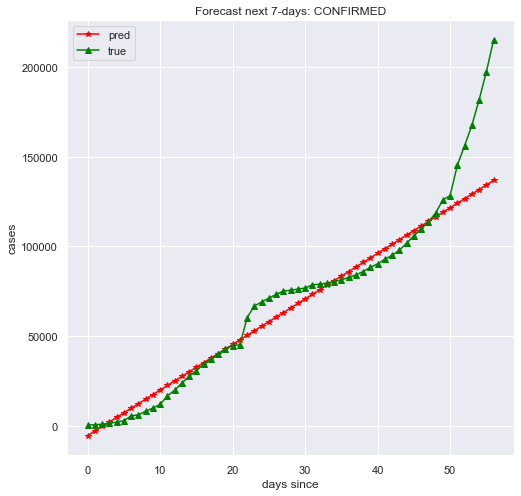

Scores:
------- 

Train MSE: 29924089.090712298
Train MAE: 4717.459881027738
Train R2: 0.9661250954810194


Val MSE: 203116823.76579067
Val MAE: 14121.910915039498
Val R2: 0.9688591094075079


Test MSE: 1714690666.716334
Test MAE: 32839.27931813872
Test MAPE: 18.28 %
Test R2: -0.7078505816772678


In [39]:
results = pd.DataFrame()
results['y_pred'] = regressor.predict(date_scores[X_columns])
results['y_true'] = date_scores[y_column]

plt.subplots(1, 1, figsize=(8, 8))
plt.plot(results['y_pred'], marker='*', color='red', label="pred")
plt.plot(results['y_true'], marker='^', color='green', label="true")
plt.xlabel("days since")
plt.ylabel("cases")
plt.title(f"Forecast next 7-days: {y_column[0].upper()}")
plt.legend()
plt.show()

best_score_index = np.where(cv_results['rank_test_mse'] == cv_results['rank_test_mse'].min())[0].item()

print("Scores:")
print("-"*7, "\n")
print(f"Train MSE: {np.abs(cv_results['mean_train_mse'][best_score_index])}") 
print(f"Train MAE: {np.abs(cv_results['mean_train_mae'][best_score_index])}")
print(f"Train R2: {np.abs(cv_results['mean_train_r2'][best_score_index])}")
print('\n')
print(f"Val MSE: {np.abs(cv_results['mean_test_mse'][best_score_index])}") 
print(f"Val MAE: {np.abs(cv_results['mean_test_mae'][best_score_index])}")
print(f"Val R2: {np.abs(cv_results['mean_test_r2'][best_score_index])}")
print('\n')
print(f"Test MSE: {mean_squared_error(test_scores['y_true'], test_scores['y_pred'])}")
print(f"Test MAE: {mean_absolute_error(test_scores['y_true'], test_scores['y_pred'])}")
print(f"Test MAPE: {np.around(np.mean(np.abs(test_scores['y_true'] - test_scores['y_pred'])/test_scores['y_true'])*100.0, 2)} %")
print(f"Test R2: {r2_score(test_scores['y_true'], test_scores['y_pred'])}")

# Conclusion

Linear regression is not a good model to predict corona case.